<a href="https://colab.research.google.com/github/sohaniyewale/internship/blob/main/interns2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving house-prices-advanced-regression-techniques.zip to house-prices-advanced-regression-techniques.zip
Shape: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  .

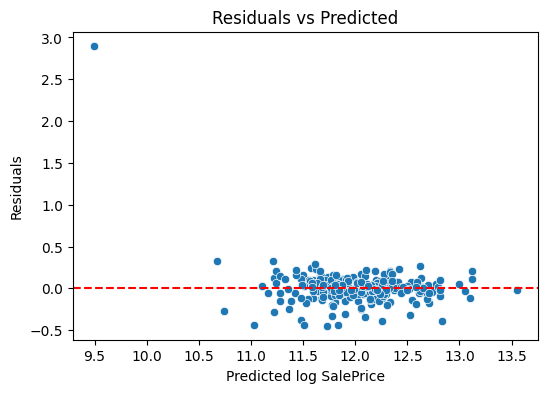

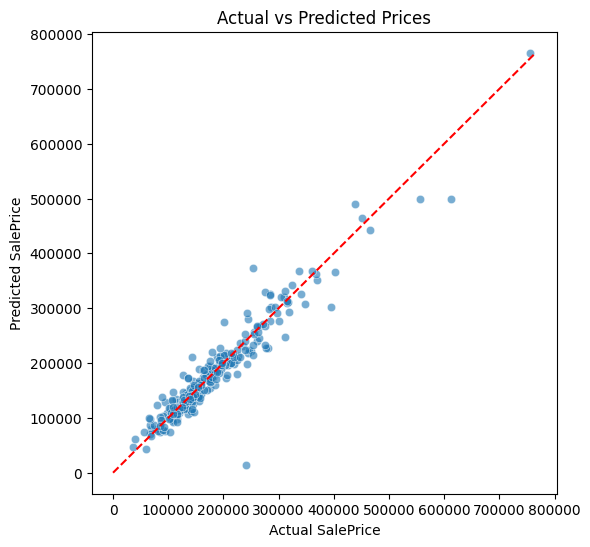

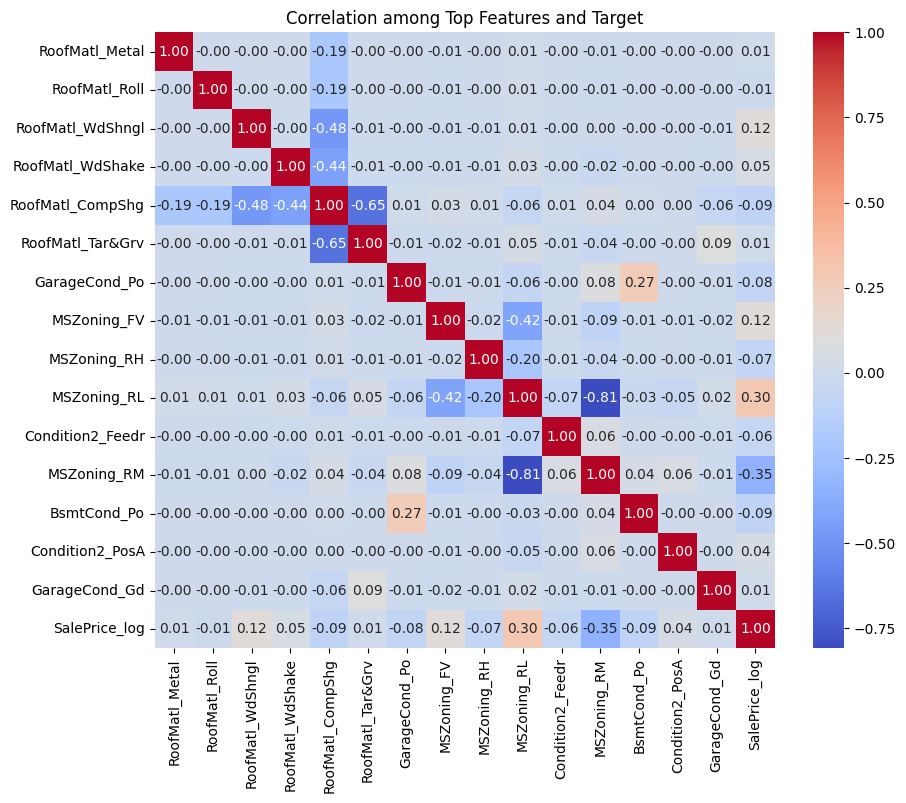

In [2]:

from google.colab import files
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


uploaded = files.upload()

with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip", 'r') as zip_ref:
    zip_ref.extractall("house_prices")


df = pd.read_csv("house_prices/train.csv")
print("Shape:", df.shape)
print(df.head())


drop_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna("None")

df["SalePrice_log"] = np.log1p(df["SalePrice"])


df = pd.get_dummies(df, drop_first=True)


from sklearn.model_selection import train_test_split

X = df.drop(columns=['SalePrice', 'SalePrice_log', 'Id'], errors='ignore')
y = df['SalePrice_log']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


lr = LinearRegression()
lr.fit(X_train, y_train)


ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)


lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(X_train, y_train)


def evaluate(model, name):
    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), y_pred))
    r2 = r2_score(np.expm1(y_val), y_pred)
    print(f"{name} RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return y_pred, rmse, r2

y_pred_lr, rmse_lr, r2_lr = evaluate(lr, "Linear Regression")
y_pred_ridge, rmse_ridge, r2_ridge = evaluate(ridge, "Ridge Regression")
y_pred_lasso, rmse_lasso, r2_lasso = evaluate(lasso, "Lasso Regression")


plt.figure(figsize=(6,4))
sns.scatterplot(x=lr.predict(X_val), y=(y_val - lr.predict(X_val)))
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted log SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


plt.figure(figsize=(6,6))
sns.scatterplot(x=np.expm1(y_val), y=y_pred_lr, alpha=0.6)
plt.plot([0, max(y_pred_lr)], [0, max(y_pred_lr)], color="red", linestyle="--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted Prices")
plt.show()


coef = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
top_feats = coef.head(15).index.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[top_feats + ["SalePrice_log"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation among Top Features and Target")
plt.show()
